### This is a simple notebook to train a Support Vector Machine to discriminate between two types of collisional events.

It accompanies Chapter 4 of the book.

Data for this exercise were kindly provided by [Sascha Caron](https://www.nikhef.nl/~scaron/).

Copyright: Viviana Acquaviva (2023)

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.svm import SVC, LinearSVC # New algorithm!
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV # New! This will be used to explore different hyperparameter choices.

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)
rc('text', usetex=False)

### The first part of this notebook is to show the manipulation I did to get the data in the format we need and to select a random sample to keep things more manageable.

You don't need to run it!

In [1]:
df = pd.read_csv('TrainingValidationData.csv', delimiter=',', names=list(['P'+str(i) for i in range(53)]) )
print(df.columns)

NameError: name 'pd' is not defined

In [ ]:
df.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,P38,P39,P40,P41,P42,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52
0,0;ttbar;0.00167779;17742.1;-2.37367;j,193103.0,143393.0,0.803969,-0.198431;j,778814.0,104707.0,2.695040,-3.03908;j,125976.0,85268.9,-0.934506,3.1025;b,69106.5,55957.8,-0.661401,0.937923;j,50482.4,39522.4,0.687292,0.839734;j,82162.7,37182.8,1.426130,-0.0749548;j,638681.0,24114.8,-3.96928,3.13769;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1;ttbar;0.00167779;15567.8;-2.90015;b,183399.0,105032.0,1.153790,-2.43549;j,166852.0,93020.5,1.186420,0.203206;j,49938.5,48836.5,0.136584,0.00672176;j,168744.0,23995.2,-2.637880,2.31197;e+,32046.3,27560.8,0.563054,1.71034;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2;ttbar;0.0334195;30647.2;2.74336;j,420301.0,135727.0,-1.792050,-0.609116;j,294268.0,78516.8,-1.994660,-2.51345;b,194433.0,67511.8,-1.716620,0.314709;j,78721.8,50067.6,1.014570,1.72546;j,60548.4,50035.6,0.620308,2.79499;b,41859.8,39719.8,-0.279838,-3.04737;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3;4top;1.93132e-07;27699.6;0.617912;j,300154.0,277869.0,-0.370231,-0.684062;j,261232.0,206121.0,0.698378,1.81692;j,258771.0,166742.0,-1.006300,-1.8801;j,145917.0,142031.0,0.159003,2.47523;j,67064.7,46427.1,-0.888082,2.22281;j,328441.0,43982.4,2.698900,0.0610803;j,62307.4,28564.1,1.39952,-2.892;m+,65374.6,53015.1,-0.670218,0.241486;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4;ttbar;0.00167779;92205.9;1.57425;j,140760.0,75721.7,-1.225510,-2.92616;j,1650250.0,68573.0,-3.873460,-0.941662;j,199485.0,39008.3,-2.314910,-2.15216;j,36111.1,32994.1,-0.399817,1.25275;j,133019.0,29239.5,-2.194640,-0.13927;m-,31258.4,27580.9,-0.510817,2.75758;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
new = df['P0'].str.split(';',expand=True)

new.columns = ['numID', 'processID', 'weight', 'MET', 'METphi', 'Type_1']

In [ ]:
new.head()

,numID,processID,weight,MET,METphi,Type_1
0,0,ttbar,0.00167779,17742.1,-2.37367,j
1,1,ttbar,0.00167779,15567.8,-2.90015,b
2,2,ttbar,0.0334195,30647.2,2.74336,j
3,3,4top,1.93132e-07,27699.6,0.617912,j
4,4,ttbar,0.00167779,92205.9,1.57425,j


In [ ]:
df = df.join(new, how='outer') #join them side to side

In [ ]:
df.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,P38,P39,P40,P41,P42,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52,numID,processID,weight,MET,METphi,Type_1
0,0;ttbar;0.00167779;17742.1;-2.37367;j,193103.0,143393.0,0.803969,-0.198431;j,778814.0,104707.0,2.695040,-3.03908;j,125976.0,85268.9,-0.934506,3.1025;b,69106.5,55957.8,-0.661401,0.937923;j,50482.4,39522.4,0.687292,0.839734;j,82162.7,37182.8,1.426130,-0.0749548;j,638681.0,24114.8,-3.96928,3.13769;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,ttbar,0.00167779,17742.1,-2.37367,j
1,1;ttbar;0.00167779;15567.8;-2.90015;b,183399.0,105032.0,1.153790,-2.43549;j,166852.0,93020.5,1.186420,0.203206;j,49938.5,48836.5,0.136584,0.00672176;j,168744.0,23995.2,-2.637880,2.31197;e+,32046.3,27560.8,0.563054,1.71034;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,ttbar,0.00167779,15567.8,-2.90015,b
2,2;ttbar;0.0334195;30647.2;2.74336;j,420301.0,135727.0,-1.792050,-0.609116;j,294268.0,78516.8,-1.994660,-2.51345;b,194433.0,67511.8,-1.716620,0.314709;j,78721.8,50067.6,1.014570,1.72546;j,60548.4,50035.6,0.620308,2.79499;b,41859.8,39719.8,-0.279838,-3.04737;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,ttbar,0.0334195,30647.2,2.74336,j
3,3;4top;1.93132e-07;27699.6;0.617912;j,300154.0,277869.0,-0.370231,-0.684062;j,261232.0,206121.0,0.698378,1.81692;j,258771.0,166742.0,-1.006300,-1.8801;j,145917.0,142031.0,0.159003,2.47523;j,67064.7,46427.1,-0.888082,2.22281;j,328441.0,43982.4,2.698900,0.0610803;j,62307.4,28564.1,1.39952,-2.892;m+,65374.6,53015.1,-0.670218,0.241486;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,4top,1.93132e-07,27699.6,0.617912,j
4,4;ttbar;0.00167779;92205.9;1.57425;j,140760.0,75721.7,-1.225510,-2.92616;j,1650250.0,68573.0,-3.873460,-0.941662;j,199485.0,39008.3,-2.314910,-2.15216;j,36111.1,32994.1,-0.399817,1.25275;j,133019.0,29239.5,-2.194640,-0.13927;m-,31258.4,27580.9,-0.510817,2.75758;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,ttbar,0.00167779,92205.9,1.57425,j


#### The new columns have been appended at the end; we still need to split the type of product.

In [ ]:
for i in range(4,53,4):

    new = df['P'+str(i)].str.split(';',expand=True) 
    
    df['P'+str(i)] = new[0]
    
    df['Type_'+str(int(i/4+1))] = new[1]
    
print(df.columns)

Index(['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10',
       'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20',
       'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30',
       'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40',
       'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P50',
       'P51', 'P52', 'numID', 'processID', 'weight', 'MET', 'METphi', 'Type_1',
       'Type_2', 'Type_3', 'Type_4', 'Type_5', 'Type_6', 'Type_7', 'Type_8',
       'Type_9', 'Type_10', 'Type_11', 'Type_12', 'Type_13', 'Type_14'],
      dtype='object')


In [ ]:
df = df.drop('P0', axis=1)

In [ ]:
df.columns.values

array(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20',
       'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29',
       'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38',
       'P39', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47',
       'P48', 'P49', 'P50', 'P51', 'P52', 'numID', 'processID', 'weight',
       'MET', 'METphi', 'Type_1', 'Type_2', 'Type_3', 'Type_4', 'Type_5',
       'Type_6', 'Type_7', 'Type_8', 'Type_9', 'Type_10', 'Type_11',
       'Type_12', 'Type_13', 'Type_14'], dtype=object)

In [ ]:
#just re-ordering

cols = ['numID', 'processID', 'weight',
       'MET', 'METphi', 'Type_1', 'P1', 'P2', 'P3', 'P4',  'Type_2', 'P5', 'P6', 'P7', 'P8', 'Type_3', 'P9', 'P10', 'P11',
       'P12',  'Type_4', 'P13', 'P14', 'P15', 'P16', 'Type_5','P17', 'P18', 'P19', 'P20',
       'Type_6','P21', 'P22', 'P23', 'P24', 'Type_7','P25', 'P26', 'P27', 'P28', 'Type_8','P29',
       'P30', 'P31', 'P32', 'Type_9', 'P33', 'P34', 'P35', 'P36', 'Type_10','P37', 'P38',
       'P39', 'P40', 'Type_11', 'P41', 'P42', 'P43', 'P44', 'Type_12', 'P45', 'P46', 'P47',
       'P48', 'Type_13','P49', 'P50', 'P51', 'P52']

In [ ]:
X = df[cols].drop(['numID', 'processID', 'weight'], axis = 1)

In [ ]:
len(cols)

70

In [ ]:
X.head() 

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52
0,17742.1,-2.37367,j,193103.0,143393.0,0.803969,-0.198431,j,778814.0,104707.0,2.695040,-3.03908,j,125976.0,85268.9,-0.934506,3.1025,b,69106.5,55957.8,-0.661401,0.937923,j,50482.4,39522.4,0.687292,0.839734,j,82162.7,37182.8,1.426130,-0.0749548,j,638681.0,24114.8,-3.96928,3.13769,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15567.8,-2.90015,b,183399.0,105032.0,1.153790,-2.43549,j,166852.0,93020.5,1.186420,0.203206,j,49938.5,48836.5,0.136584,0.00672176,j,168744.0,23995.2,-2.637880,2.31197,e+,32046.3,27560.8,0.563054,1.71034,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30647.2,2.74336,j,420301.0,135727.0,-1.792050,-0.609116,j,294268.0,78516.8,-1.994660,-2.51345,b,194433.0,67511.8,-1.716620,0.314709,j,78721.8,50067.6,1.014570,1.72546,j,60548.4,50035.6,0.620308,2.79499,b,41859.8,39719.8,-0.279838,-3.04737,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27699.6,0.617912,j,300154.0,277869.0,-0.370231,-0.684062,j,261232.0,206121.0,0.698378,1.81692,j,258771.0,166742.0,-1.006300,-1.8801,j,145917.0,142031.0,0.159003,2.47523,j,67064.7,46427.1,-0.888082,2.22281,j,328441.0,43982.4,2.698900,0.0610803,j,62307.4,28564.1,1.39952,-2.892,m+,65374.6,53015.1,-0.670218,0.241486,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92205.9,1.57425,j,140760.0,75721.7,-1.225510,-2.92616,j,1650250.0,68573.0,-3.873460,-0.941662,j,199485.0,39008.3,-2.314910,-2.15216,j,36111.1,32994.1,-0.399817,1.25275,j,133019.0,29239.5,-2.194640,-0.13927,m-,31258.4,27580.9,-0.510817,2.75758,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X.describe() #remember that this only affects numerical columns

,P1,P2,P3,P5,P6,P7,P9,P10,P11,P13,P14,P15,P17,P18,P19,P21,P22,P23,P25,P26,P27,P29,P30,P31,P33,P34,P35,P37,P38,P39,P41,P42,P43,P45,P46,P47,P49,P50,P51
count,9.999700e+04,9.999700e+04,99997.000000,9.992600e+04,9.992600e+04,99926.000000,9.899100e+04,98991.000000,98991.000000,9.385300e+04,93853.000000,93853.000000,7.991000e+04,79910.000000,79910.000000,5.853900e+04,58539.000000,58539.000000,3.834700e+04,38347.000000,38347.000000,2.412200e+04,24122.000000,24122.000000,1.513400e+04,15134.000000,15134.000000,9.011000e+03,9011.000000,9011.000000,4.853000e+03,4853.000000,4853.000000,2.361000e+03,2361.000000,2361.000000,9.670000e+02,967.000000,967.000000
mean,3.277655e+05,1.545569e+05,-0.003555,2.502158e+05,1.077661e+05,0.002952,2.060598e+05,74817.281537,-0.002819,1.824161e+05,57910.555406,-0.002839,1.721824e+05,48861.000075,-0.004951,1.684729e+05,44167.725923,-0.002462,1.664557e+05,41661.123342,-0.000830,1.651800e+05,40757.138956,0.003005,1.654103e+05,40760.175268,0.000550,1.615391e+05,40610.894030,0.013680,1.570275e+05,38895.164290,-0.025059,1.603781e+05,38429.168022,-0.035858,1.616734e+05,38770.992037,-0.040558
std,2.992857e+05,1.123455e+05,1.350584,2.563849e+05,7.614375e+04,1.422386,2.472275e+05,44171.199946,1.542322,2.388193e+05,31288.049544,1.640667,2.406316e+05,25329.276228,1.721809,2.368950e+05,22788.335816,1.788698,2.337867e+05,22879.841904,1.834066,2.340694e+05,25917.855025,1.852271,2.272069e+05,30147.319141,1.878538,2.197876e+05,34899.356724,1.881599,2.123164e+05,31830.501192,1.894229,2.151410e+05,32762.774784,1.932522,2.074495e+05,34184.668553,1.967807
min,2.089250e+04,1.838530e+04,-4.856300,1.087540e+04,1.007280e+04,-4.788360,1.027220e+04,10023.400000,-4.892440,1.001200e+04,10004.200000,-4.897010,1.034400e+04,10006.000000,-4.893080,1.028280e+04,10006.500000,-4.930230,1.013400e+04,10009.700000,-4.920570,1.048510e+04,10060.300000,-4.921770,1.022420e+04,10009.300000,-4.884880,1.047610e+04,10046.100000,-4.814330,1.116940e+04,10047.300000,-4.841310,1.068020e+04,10024.700000,-4.802890,1.163680e+04,10051.900000,-4.641500
25%,1.371900e+05,8.806960e+04,-0.987878,9.961972e+04,6.373630e+04,-1.009580,7.534165e+04,47026.900000,-1.078880,6.102030e+04,36720.200000,-1.143060,5.329685e+04,31383.600000,-1.198820,4.980905e+04,28825.100000,-1.250715,4.830010e+04,27846.900000,-1.281040,4.725083e+04,27306.075000,-1.306000,4.541188e+04,26804.550000,-1.324485,4.401945e+04,26325.600000,-1.308170,4.249970e+04,25749.300000,-1.405300,4.176920e+04,25207.400000,-1.449130,4.220260e+04,25020.900000,-1.479920
50%,2.262300e+05,1.196960e+05,-0.003297,1.640690e+05,8.635380e+04,-0.002509,1.250130e+05,63189.700000,-0.006581,1.025380e+05,49475.900000,-0.006059,9.069685e+04,41449.600000,-0.006588,8.574750e+04,37348.500000,-0.001917,8.353000e+04,35312.000000,-0.008763,8.144470e+04,34131.000000,-0.003657,8.182995e+04,32771.700000,-0.010745,7.986780e+04,31232.700000,-0.008984,7.873760e+04,29879.400000,-0.044943,8.083190e+04,28659.200000,-0.056851,8.570070e+04,27715.200000,-0.105207
75%,4.073950e+05,1.774540e+05,0.987178,2.999222e+05,1.248410e+05,1.014055,2.319710e+05,89264.600000,1.078430,1.976550e+05,69872.000000,1.136430,1.799680e+05,58829.725000,1.189717,1.767390e+05,52490.200000,1.254020,1.772160e+05,48534.650000,1.301125,1.750300e+05,45545.350000,1.320450,1.822572e+05,42861.950000,1.336268,1.825300e+05,40546.250000,1.354115,1.738650e+05,37468.000000,1.328520,1.805500e+05,36375.500000,1.373420,1.844370e+05,34013.050000,1.425335
max,3.783780e+06,1.768980e+06,4.796060,4.379710e+06,1.687820e+06,4.810550,3.823240e+06,788338.000000,4.844930,4.126560e+06,481884.000000,4.887670,3.835360e+06,499118.000000,4.900040,3.833440e+06,504952.000000,4.943350,3.093440e+06,545365.000000,4.879880,3.167930e+06,860415.000000,4.866710,2.590720e+06,679264.000000,4.873490,2.296100e+06,732108.000000,4.845880,2.430440e+06,559006.000000,4.790720,1.888880e+06,384298.000000,4.849800,1.892590e+06,302147.000000,4.662020


Some columns that should be numerical are of type "object"

In [ ]:
X.columns[X.dtypes == object]

Index(['MET', 'METphi', 'Type_1', 'P4', 'Type_2', 'P8', 'Type_3', 'P12',
       'Type_4', 'P16', 'Type_5', 'P20', 'Type_6', 'P24', 'Type_7', 'P28',
       'Type_8', 'P32', 'Type_9', 'P36', 'Type_10', 'P40', 'Type_11', 'P44',
       'Type_12', 'P48', 'Type_13', 'P52'],
      dtype='object')

Re-cast data type where appropriate

In [ ]:
for el in ['MET', 'METphi', 'P4', 'P8', 'P12',
        'P16',  'P20', 'P24',  'P28',
    'P32', 'P36', 'P40', 'P44',
      'P48', 'P52']:
    X[el] = X[el].astype('float64')

In [ ]:
X.dtypes

MET        float64
METphi     float64
Type_1      object
P1         float64
P2         float64
P3         float64
P4         float64
Type_2      object
P5         float64
P6         float64
P7         float64
P8         float64
Type_3      object
P9         float64
P10        float64
P11        float64
P12        float64
Type_4      object
P13        float64
P14        float64
P15        float64
P16        float64
Type_5      object
P17        float64
P18        float64
P19        float64
P20        float64
Type_6      object
P21        float64
P22        float64
P23        float64
P24        float64
Type_7      object
P25        float64
P26        float64
P27        float64
P28        float64
Type_8      object
P29        float64
P30        float64
P31        float64
P32        float64
Type_9      object
P33        float64
P34        float64
P35        float64
P36        float64
Type_10     object
P37        float64
P38        float64
P39        float64
P40        float64
Type_11     

#### Select 5000 rows

In [ ]:
np.random.seed(10)

sel = np.random.choice(df.shape[0], 5000)

features = X.iloc[sel,:]

In [ ]:
features.shape

(5000, 67)

In [ ]:
features.columns

Index(['MET', 'METphi', 'Type_1', 'P1', 'P2', 'P3', 'P4', 'Type_2', 'P5', 'P6',
       'P7', 'P8', 'Type_3', 'P9', 'P10', 'P11', 'P12', 'Type_4', 'P13', 'P14',
       'P15', 'P16', 'Type_5', 'P17', 'P18', 'P19', 'P20', 'Type_6', 'P21',
       'P22', 'P23', 'P24', 'Type_7', 'P25', 'P26', 'P27', 'P28', 'Type_8',
       'P29', 'P30', 'P31', 'P32', 'Type_9', 'P33', 'P34', 'P35', 'P36',
       'Type_10', 'P37', 'P38', 'P39', 'P40', 'Type_11', 'P41', 'P42', 'P43',
       'P44', 'Type_12', 'P45', 'P46', 'P47', 'P48', 'Type_13', 'P49', 'P50',
       'P51', 'P52'],
      dtype='object')

Reset index

In [ ]:
features.reset_index(drop=True, inplace=True)

In [ ]:
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,0.826569,2.332000,b,86788.9,84554.9,-0.180795,2.187970,j,140289.0,76955.8,-1.19933,-1.302800,m+,85230.6,70102.4,-0.645689,-1.659540,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,-2.126740,-2.582310,e-,44270.1,35139.6,-0.706120,-0.371392,e+,72883.9,26902.2,-1.65386,-3.129630,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,1.226850,0.646589,j,60768.9,36244.3,1.102890,-1.434480,j,77714.0,27801.5,1.68461,1.389690,j,26840.0,24469.3,-0.388937,-1.647260,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,-0.024646,-2.222800,j,201589.0,32978.6,-2.496040,1.137810,j,90096.7,26964.5,1.87132,0.817631,j,28235.4,25887.9,-0.411528,2.024290,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,0.774114,2.568740,j,61625.2,50086.7,0.652572,-3.012800,j,104193.0,31151.0,1.87641,0.865381,j,746585.0,26219.3,4.041820,-0.874169,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Export feature data frame to file

In [ ]:
features.to_csv('ParticleID_features.csv', index_label= 'ID')

#### Select labels

In [ ]:
y = df.processID[sel].values # values makes it an array

In [ ]:
y

array(['ttbar', 'ttbar', 'ttbar', ..., 'ttbar', '4top', 'ttbar'],
      dtype=object)

#### Export labels to file

In [ ]:
np.savetxt('ParticleID_labels.txt', y, fmt = '%s')

## Start here!

Read in features and labels.

In [3]:
features = pd.read_csv('ParticleID_features.csv', index_col='ID')

In [4]:
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,0.826569,2.332000,b,86788.9,84554.9,-0.180795,2.187970,j,140289.0,76955.8,-1.19933,-1.302800,m+,85230.6,70102.4,-0.645689,-1.659540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,-2.126740,-2.582310,e-,44270.1,35139.6,-0.706120,-0.371392,e+,72883.9,26902.2,-1.65386,-3.129630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,1.226850,0.646589,j,60768.9,36244.3,1.102890,-1.434480,j,77714.0,27801.5,1.68461,1.389690,j,26840.0,24469.3,-0.388937,-1.647260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,-0.024646,-2.222800,j,201589.0,32978.6,-2.496040,1.137810,j,90096.7,26964.5,1.87132,0.817631,j,28235.4,25887.9,-0.411528,2.024290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,0.774114,2.568740,j,61625.2,50086.7,0.652572,-3.012800,j,104193.0,31151.0,1.87641,0.865381,j,746585.0,26219.3,4.041820,-0.874169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
features.shape

(5000, 67)

In [6]:
y = np.genfromtxt('ParticleID_labels.txt', dtype = str)

In [7]:
y

array(['ttbar', 'ttbar', 'ttbar', ..., 'ttbar', '4top', 'ttbar'],
      dtype='<U5')

#### We need to turn categorical (string-type) labels into an array, e.g. 0/1.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() #turns categorical into 1 ... N

In [9]:
y

array(['ttbar', 'ttbar', 'ttbar', ..., 'ttbar', '4top', 'ttbar'],
      dtype='<U5')

In [10]:
y = le.fit_transform(y)

In [11]:
y 

array([1, 1, 1, ..., 1, 0, 1])

Our transformer used 1 for the first instance, but we actually wanted 4top to be the positive label, so we'll flip the labels:

In [12]:
target = np.abs(y - 1)

In [13]:
target # Happier now.

array([0, 0, 0, ..., 0, 1, 0])

#### Let's take a look at these features, using the "describe" property.

In [14]:
features.describe() #Note that this automatically excludes non-numerical type columns

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,P38,P39,P40,P41,P42,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,4.997000e+03,4.997000e+03,4997.000000,4997.000000,4.950000e+03,4950.000000,4950.000000,4950.000000,4.717000e+03,4717.000000,4717.000000,4717.000000,4.002000e+03,4002.000000,4002.000000,4002.000000,2.871000e+03,2871.00000,2871.000000,2871.000000,1.889000e+03,1889.000000,1889.000000,1889.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,7.290000e+02,729.000000,729.000000,729.000000,4.420000e+02,442.000000,442.000000,442.000000,2.610000e+02,261.000000,261.000000,261.000000,1.270000e+02,127.000000,127.000000,127.000000,5.600000e+01,56.000000,56.000000,56.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.527799e+05,1.080302e+05,-0.029936,0.007327,2.117980e+05,74863.343131,-0.025104,0.011845,1.805997e+05,57289.049481,0.010723,0.045266,1.780366e+05,48798.018516,0.015167,-0.031312,1.705620e+05,44042.67015,-0.022948,0.014522,1.628825e+05,41151.069666,0.002228,0.006738,1.581409e+05,40250.387015,0.072349,-0.035907,1.596814e+05,40139.289849,0.061654,-0.045868,1.574039e+05,39703.038235,0.118543,0.024249,1.561160e+05,38173.716092,0.029455,0.026422,1.631051e+05,34876.849606,0.206978,-0.001085,1.456600e+05,36151.183929,-0.000879,0.219260
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638580e+05,8.136261e+04,1.439105,1.828832,2.510361e+05,46309.512365,1.577316,1.802715,2.383403e+05,32013.857623,1.634072,1.812078,2.577958e+05,26252.978520,1.744489,1.784248,2.381745e+05,23510.65367,1.806611,1.811101,2.269341e+05,20988.953157,1.815312,1.771888,2.118782e+05,26556.025657,1.836492,1.796932,2.308620e+05,30074.756789,1.842798,1.788596,2.165489e+05,30502.312276,1.872084,1.826435,2.319016e+05,29324.658352,1.884750,1.753017,2.248603e+05,20433.767238,1.998859,1.949004,1.943657e+05,25861.883410,1.941707,1.910400
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,1.087540e+04,1.080000e+04,-4.668790,-3.140530,1.221050e+04,10639.800000,-4.520250,-3.141480,1.169190e+04,10818.000000,-4.616550,-3.136130,1.110310e+04,10287.000000,-4.778980,-3.139040,1.070330e+04,10066.90000,-4.930230,-3.140380,1.197700e+04,11260.200000,-4.758150,-3.135630,1.380860e+04,10973.300000,-4.606330,-3.132610,1.119760e+04,10067.900000,-4.814380,-3.136380,1.615530e+04,10183.700000,-4.803880,-3.135910,2.004750e+04,14800.200000,-4.400470,-3.130690,1.780380e+04,12987.900000,-4.447660,-3.139820,2.512510e+04,14836.000000,-4.448760,-2.990730
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007510e+05,6.321840e+04,-1.060500,-1.602460,7.636905e+04,46549.475000,-1.125620,-1.547418,5.999090e+04,36097.700000,-1.121240,-1.518030,5.278370e+04,30891.650000,-1.198468,-1.550615,5.007050e+04,28453.95000,-1.250050,-1.586675,4.695560e+04,27963.500000,-1.231420,-1.475380,4.535515e+04,27140.550000,-1.243962,-1.626688,4.387110e+04,26825.000000,-1.226980,-1.513330,4.410735e+04,26589.250000,-1.223240,-1.422415,4.092160e+04,25298.300000,-1.413650,-1.270700,4.365005e+04,24742.500000,-1.259230,-1.817600,4.112588e+04,24974.125000,-1.243362,-1.490900
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.659740e+05,8.584360e+04,-0.057429,0.015111,1.288565e+05,62498.400000,-0.040648,0.034238,9.922610e+04,48949.200000,-0.035512,0.060279,9.206885e+04,41054.850000,0.054393,-0.079641,8.593460e+04,37378.30000,-0.046667,0.040528,7.975460e+04,34681.700000,0.025305,0.046141,8.315485e+04,33683.550000,0.156083,-0.015617,7.894980e+04,33328.000000,0.072709,-0.052590,7.609735e+04,30942.700000,0.035675,0.090282,7.568430e+04,29479.700000,-0.088908,-0.041002,8.050910e+04,28262.800000,0.120301,-0.232455,9.553645e+04,27353.550000,-0.121213,0.128103
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.9999

### Important:

Looking at the "count" row, we can see that the whole data set has 5,000 rows, but some columns are present only for a fraction of them. This is because of the variable number of products in each collision.

#### Option 1: Only consider first 16 columns (first four products) so we have limited imputing/manipulation problems.

We have a trade-off between keeping more features, but having a more severe missing data/imputing problem, or keeping fewer features, but dealing with a simpler imputing problem. We are choosing the latter.

In [15]:
features_lim = features[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', 'P16']]

In [16]:
features_lim.head()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
ID,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,137571.0,128444.0,-0.345744,-0.307112,174209.0,127932.0,0.826569,2.332000,86788.9,84554.9,-0.180795,2.187970,140289.0,76955.8,-1.19933,-1.302800
1,57594.2,-0.509253,161529.0,80458.3,-1.318010,1.402050,291490.0,68462.9,-2.126740,-2.582310,44270.1,35139.6,-0.706120,-0.371392,72883.9,26902.2,-1.65386,-3.129630
2,82313.3,1.686840,167130.0,113078.0,0.937258,-2.068680,102423.0,54922.3,1.226850,0.646589,60768.9,36244.3,1.102890,-1.434480,77714.0,27801.5,1.68461,1.389690
3,30610.8,2.617120,112267.0,61383.9,-1.211050,-1.457800,40647.8,39472.0,-0.024646,-2.222800,201589.0,32978.6,-2.496040,1.137810,90096.7,26964.5,1.87132,0.817631
4,45153.1,-2.241350,178174.0,100164.0,1.166880,-0.018721,92351.3,69762.1,0.774114,2.568740,61625.2,50086.7,0.652572,-3.012800,104193.0,31151.0,1.87641,0.865381


In [17]:
features_lim.describe() #This automatically excludes non-numerical type columns, and missing values/NaNs are not counted.

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,4.997000e+03,4.997000e+03,4997.000000,4997.000000,4.950000e+03,4950.000000,4950.000000,4950.000000,4.717000e+03,4717.000000,4717.000000,4717.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.527799e+05,1.080302e+05,-0.029936,0.007327,2.117980e+05,74863.343131,-0.025104,0.011845,1.805997e+05,57289.049481,0.010723,0.045266
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638580e+05,8.136261e+04,1.439105,1.828832,2.510361e+05,46309.512365,1.577316,1.802715,2.383403e+05,32013.857623,1.634072,1.812078
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,1.087540e+04,1.080000e+04,-4.668790,-3.140530,1.221050e+04,10639.800000,-4.520250,-3.141480,1.169190e+04,10818.000000,-4.616550,-3.136130
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007510e+05,6.321840e+04,-1.060500,-1.602460,7.636905e+04,46549.475000,-1.125620,-1.547418,5.999090e+04,36097.700000,-1.121240,-1.518030
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.659740e+05,8.584360e+04,-0.057429,0.015111,1.288565e+05,62498.400000,-0.040648,0.034238,9.922610e+04,48949.200000,-0.035512,0.060279
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.999950e+05,1.238700e+05,1.028340,1.605210,2.421225e+05,89587.500000,1.066302,1.570887,1.914340e+05,68782.100000,1.159480,1.612220
max,692674.000000,3.141130,3.186360e+06,1.276710e+06,4.141410,3.138540,3.587700e+06,1.146330e+06,4.559150,3.139200,2.800410e+06,788338.000000,4.798090,3.139020,2.503590e+06,481884.000000,4.730480,3.139660


There are still some feature columns with different length! This means there might be NaN values. Let's replace them with 0 for the moment. 

In [18]:
features_lim = features_lim.fillna(0) #Fill with 0 everywhere there is a NaN

Note: this is the simplest but worst possible choice - imputing a constant value skews the model :D One step up would be to input the mean or median for each column. However, because only a limited number of instances have missing data, the choice of imputing strategy doesn't matter too much.

#### Let's see what "describe" says now.

In [19]:
features_lim.describe()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.526283e+05,1.079653e+05,-0.029918,0.007323,2.096800e+05,74114.709700,-0.024853,0.011727,1.703778e+05,54046.489280,0.010116,0.042704
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638514e+05,8.138121e+04,1.438673,1.828283,2.506651e+05,46675.655162,1.569410,1.793678,2.352279e+05,33795.723384,1.587146,1.760070
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,0.000000e+00,0.000000e+00,-4.668790,-3.140530,0.000000e+00,0.000000,-4.520250,-3.141480,0.000000e+00,0.000000,-4.616550,-3.136130
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007050e+05,6.320943e+04,-1.059270,-1.599617,7.488228e+04,46165.375000,-1.108390,-1.532478,5.480870e+04,33959.400000,-1.050477,-1.424080
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.658985e+05,8.581595e+04,-0.056810,0.012737,1.277135e+05,62167.100000,-0.023321,0.006687,9.259335e+04,47278.800000,0.000000,0.000000
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.999058e+05,1.238520e+05,1.028055,1.601880,2.406498e+05,89065.300000,1.048617,1.553310,1.831228e+05,66846.300000,1.085627,1.521765
max,692674.000000,3.141130,3.186360e+06,1.276710e+06,4.141410,3.138540,3.587700e+06,1.146330e+06,4.559150,3.139200,2.800410e+06,788338.000000,4.798090,3.139020,2.503590e+06,481884.000000,4.730480,3.139660


Yay - we now have consistent sizes, so we can use these as feature arrays, BUT be mindful of possible negative impacts of our imputing strategies.

### Let's move onto a quick exploration of labels and benchmarking.

In [20]:
np.sum(target)/len(target) #distribution 

0.1622

84\% in the negative label, 16\% in the positive label. 

This means that a classifier that puts everything in the negative class will have 84\% accuracy.

How about a random classifier that just assigns a random value according to class distribution?

In [21]:
#Numerical solution

acc=0
for i in range(1000):
    x = np.random.choice(target,5000)
    acc += metrics.accuracy_score(target,x)
print(acc/1000)

#Analytic solution 

print(0.8378*(0.8378) + 0.1622*0.1622)

0.7282757999999995
0.72821768


In conclusion, a "random" classifier would have 73% accuracy; a dummy classifier that predicts the most frequent class would have 83% accuracy. These are useful in order to set the expectation for what "a good result" is and what constitutes a significant improvement.

### Let's start with a linear model; model = SVC()

Define a cross-validation strategy; establish benchmark for a linear model.

In [22]:
bmodel = LinearSVC(dual = False) #Prefer dual=False when n_samples > n_features. If not, will not converge!!

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) 

In [24]:
l_benchmark_lim = cross_validate(bmodel, features_lim, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [25]:
l_benchmark_lim

{'fit_time': array([0.01978707, 0.01359487, 0.01191783, 0.00882816, 0.00913692]),
 'score_time': array([0.00240898, 0.00167298, 0.00130987, 0.00099468, 0.00083184]),
 'test_score': array([0.841, 0.825, 0.829, 0.83 , 0.833]),
 'train_score': array([0.8315 , 0.83275, 0.8315 , 0.83125, 0.832  ])}

In [26]:
np.round(l_benchmark_lim['test_score'].mean(),3), np.round(l_benchmark_lim['test_score'].std(), 3)

(0.832, 0.005)

This may look like a good number, but we know that it's not that impressive, as it merely matches a "dummy" classifier.

We can also check the predicted labels. Cross\_val\_predict will compile labels predicted when each object was in the test fold.

In [27]:
ypred_bench_lim = cross_val_predict(bmodel, features_lim, target, cv = cv)

### Question: is there perhaps something that we should have done before building the SVM model?

### How about scaling?

Implementation notes: Technically, standardizing/normalizing data using the entire learning set introduces leakage between train and test set (the test set "knows" about the mean and standard deviation of the entire data set). Usually this is not a dramatic effect, but the correct procedure is to derive the scaler within each CV fold (i.e. after separating in train and test), only on the train set, and apply the same transformation to the test set. The model then becomes a pipeline.

In [28]:
from sklearn.pipeline import make_pipeline #This allows one to build different steps together

In [29]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False, C = 1000)) #changed to linear SVC

benchmark_lim_piped = cross_validate(piped_model, features_lim, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [30]:
benchmark_lim_piped

{'fit_time': array([0.01819301, 0.00984097, 0.01062679, 0.00893807, 0.00723696]),
 'score_time': array([0.00230408, 0.00163889, 0.00178409, 0.00123286, 0.00106907]),
 'test_score': array([0.894, 0.889, 0.89 , 0.892, 0.899]),
 'train_score': array([0.89575, 0.895  , 0.895  , 0.89825, 0.89275])}

In [31]:
np.round(benchmark_lim_piped['test_score'].mean(),3), np.round(benchmark_lim_piped['test_score'].std(), 3)

(0.893, 0.004)

In [32]:
np.round(benchmark_lim_piped['train_score'].mean(),3), np.round(benchmark_lim_piped['train_score'].std(), 3)

(0.895, 0.002)

This is a significant improvement (woo-ooh!), and the comparison between test and train scores tells us already something about the problem that we have. We can formalize this by looking at the learning curves, which tell us both about gap between train/test scores, AND whether we need more data.

### Learning curves 

In [33]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'accuracy', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("# of training examples",fontsize = 14)
 
    plt.ylabel("Accuracy score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    plt.legend(loc="best",fontsize = 12)
    return plt

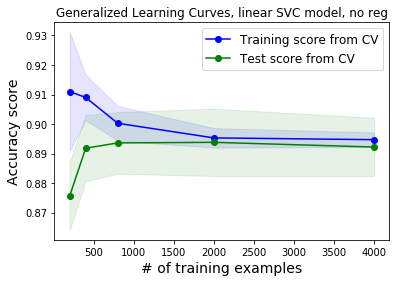

In [34]:
plot_learning_curve(piped_model, 'Generalized Learning Curves, linear SVC model, no reg', features_lim, target, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), cv = KFold(n_splits=5, shuffle=True));

### Conclusions

Our classifier is behaving better than a random/lazy one.

Our model does not suffer from high variance, so for improvement we'd look at "high bias" fixes.

Having more data would not help.

### Parameter optimization 

When we optimize parameters with a grid search, we choose the parameters that give the best test scores. This is different from what would happen with new data - to do this fairly, at no point of the training procedure we are allowed to look at the test labels. Therefore, we would need to do <b> nested cross validation </b> to avoid leakage between the parameter optimization and the cross validation procedure and properly evaluate the generalization error.

In [35]:
piped_model = make_pipeline(StandardScaler(), SVC()) #now using the general SVC so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

{'memory': None,
 'steps': [('standardscaler', StandardScaler()), ('svc', SVC())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svc': SVC(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

### We can define a dictionary of parameter values to run the optimization. 

Note that this might take a while (~5 mins on my laptop, but it was 15' on my previous laptop); the early estimates output by this cell may be misleading because more complex models (in particular high gamma) take longer.

Once you run this cell, the "model" object will have attributes "best_score_", "best_params_" and "best_estimator_", which give us access to the optimal estimator (printed out), as well as "cv_results_" that can be used to visualize the performance of all models.

In [36]:
#optimizing SVC: THIS IS NOT YET NESTED CV

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':[0.00001,'scale', 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svc__degree': [2, 4, 8]}

model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)

model.fit(features_lim,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params, best score: 0.8946 {'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


#### Next, we visualize the models in a data frame, and rank them according to their test scores.

I like to look at the mean and std of the test scores, the mean of the train scores (so I can evaluate if they differ and the significance of the result), and also fitting time (we may pick a faster model instead of the best model if the scores are comparable)!

In [41]:
scores_lim = pd.DataFrame(model.cv_results_)

scores_lim.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_svc__C', 'param_svc__degree', 'param_svc__gamma',
       'param_svc__kernel', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

In [42]:
scores_lim[['params','mean_test_score','std_test_score','mean_train_score', \
            'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
37,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8946,0.007200,0.90020,0.164950
45,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8946,0.007200,0.90020,0.157500
29,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8946,0.007200,0.90020,0.157326
69,"{'svc__C': 10.0, 'svc__degree': 8, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8944,0.005426,0.91235,0.200096
53,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8944,0.005426,0.91235,0.192314
61,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8944,0.005426,0.91235,0.202581
35,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.8938,0.004490,0.92190,0.194579
27,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.8938,0.004490,0.92190,0.187518
43,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.8938,0.004490,0.92190,0.191469
105,"{'svc__C': 1000, 'svc__degree': 4, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.8932,0.004308,0.89475,0.203659


To build some intuition around the results, I find it helpful to ask: what hyperparameter values are common to all the best-performing models? Here, for example, the rbf kernel seems to be constantly preferred, while the values of C and gamma seem to only affect the scores only mildly. Note also that the Grid Search is insensitive to moot parameters combinations; for example, here the first three models are identical, because the degree of the polynomial kernel does not matter when using an rbf kernel. This is less than ideal, of course.

#### We can also isolate one type of kernel to look at it more closely.

In [43]:
scores_lim[scores_lim['param_svc__kernel'] == 'poly'][['params','mean_test_score','std_test_score',\
                        'mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
50,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8762,0.005706,0.88515,0.513507
26,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8758,0.005913,0.88200,0.203355
54,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8756,0.006086,0.88700,1.108503
30,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8756,0.004499,0.88425,0.285747
100,"{'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}",0.8756,0.006086,0.88700,1.364474
76,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}",0.8756,0.004499,0.88425,0.322679
74,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8752,0.006997,0.88735,3.794572
102,"{'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8752,0.007194,0.88785,136.021469
98,"{'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8750,0.007294,0.88795,39.696453
78,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8748,0.007250,0.88795,13.658873


### Final diagnosis 

The problem here is high bias, which is not that surprising given that we are using only a subset of features.

We can try two things: making up new features which might help, based on what we know about the problem, and using an imputing strategy to include information about the discarded features.

### Next step: define some new variables. 

In [44]:
features = features.fillna(0) #takes care of nan

In [45]:
features = features.replace('', 0) #takes care of empty string values

In [46]:
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,0.826569,2.332000,b,86788.9,84554.9,-0.180795,2.187970,j,140289.0,76955.8,-1.19933,-1.302800,m+,85230.6,70102.4,-0.645689,-1.659540,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,-2.126740,-2.582310,e-,44270.1,35139.6,-0.706120,-0.371392,e+,72883.9,26902.2,-1.65386,-3.129630,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,1.226850,0.646589,j,60768.9,36244.3,1.102890,-1.434480,j,77714.0,27801.5,1.68461,1.389690,j,26840.0,24469.3,-0.388937,-1.647260,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,-0.024646,-2.222800,j,201589.0,32978.6,-2.496040,1.137810,j,90096.7,26964.5,1.87132,0.817631,j,28235.4,25887.9,-0.411528,2.024290,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,0.774114,2.568740,j,61625.2,50086.7,0.652572,-3.012800,j,104193.0,31151.0,1.87641,0.865381,j,746585.0,26219.3,4.041820,-0.874169,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


#### Let's start by looking at what kind of particles we have as a product of the collision.

In [47]:
np.unique(np.array([features['Type_'+str(i)].values for i in range(1,14)]).astype('str'))

array(['0', 'b', 'e+', 'e-', 'g', 'j', 'm+', 'm-'], dtype='<U2')

#### Here are the proposed new features (justification can be found in Chapter 4).
    
    1. The total number of particles produced
    2. The total number of b jets
    3. The total number of jets
    4. The total number of leptons (electrons, positron, mu+, mu-)

In [48]:
#count number of non-zero types 

ntot = np.array([-(np.sum(np.array([features['Type_'+str(i)].values[j] == 0 for i in range(1,14)])) - 13) for j in range(features.shape[0])])

In [49]:
#define new column in my data frame

features['Total_products'] = ntot

In [50]:
#count number of b jets 

nbtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'b' for i in range(1,14)])) for j in range(features.shape[0])])

In [51]:
#define new column in my data frame

features['Total_b'] = nbtot

In [52]:
#Actually, let's count all types (jets, photons g, e-, e+, mu-, mu+)

njtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'j' for i in range(1,14)])) for j in range(features.shape[0])])

In [53]:
ngtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'g' for i in range(1,14)])) for j in range(features.shape[0])])

In [54]:
n_el_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'e-' for i in range(1,14)])) for j in range(features.shape[0])])

In [55]:
n_pos_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'e+' for i in range(1,14)])) for j in range(features.shape[0])])

In [56]:
n_muneg_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'm-' for i in range(1,14)])) for j in range(features.shape[0])])

In [57]:
n_mupos_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'm+' for i in range(1,14)])) for j in range(features.shape[0])])

In [58]:
n_lepton_tot = n_el_tot + n_pos_tot + n_muneg_tot + n_mupos_tot

And here we define the other new features:

In [59]:
features['Total_j'] = njtot
features['Total_g'] = ngtot
features['Total_leptons'] = n_lepton_tot

In [60]:
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52,Total_products,Total_b,Total_j,Total_g,Total_leptons
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,0.826569,2.332000,b,86788.9,84554.9,-0.180795,2.187970,j,140289.0,76955.8,-1.19933,-1.302800,m+,85230.6,70102.4,-0.645689,-1.659540,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,5,1,3,0,1
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,-2.126740,-2.582310,e-,44270.1,35139.6,-0.706120,-0.371392,e+,72883.9,26902.2,-1.65386,-3.129630,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,4,0,2,0,2
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,1.226850,0.646589,j,60768.9,36244.3,1.102890,-1.434480,j,77714.0,27801.5,1.68461,1.389690,j,26840.0,24469.3,-0.388937,-1.647260,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,5,1,4,0,0
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,-0.024646,-2.222800,j,201589.0,32978.6,-2.496040,1.137810,j,90096.7,26964.5,1.87132,0.817631,j,28235.4,25887.9,-0.411528,2.024290,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,5,1,4,0,0
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,0.774114,2.568740,j,61625.2,50086.7,0.652572,-3.012800,j,104193.0,31151.0,1.87641,0.865381,j,746585.0,26219.3,4.041820,-0.874169,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,5,0,5,0,0


### Feature engineering 1: impact of ad-hoc variables

In [61]:
features_lim_2 = features[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', 'P16','Total_products', 'Total_b' ,'Total_j','Total_g', 
              'Total_leptons']]

In [62]:
bmodel #remember our benchmark model?

LinearSVC(dual=False)

In [63]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False))

In [64]:
benchmark_lim2_piped = cross_validate(piped_model, features_lim_2, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [65]:
benchmark_lim2_piped

{'fit_time': array([0.02094603, 0.01097894, 0.0102272 , 0.00843215, 0.00713897]),
 'score_time': array([0.00338292, 0.00176406, 0.00172281, 0.0012958 , 0.00113511]),
 'test_score': array([0.952, 0.939, 0.961, 0.948, 0.94 ]),
 'train_score': array([0.95   , 0.9555 , 0.94825, 0.95   , 0.95   ])}

In [66]:
np.round(benchmark_lim2_piped['test_score'].mean(),3), np.round(benchmark_lim2_piped['test_score'].std(), 3)

(0.948, 0.008)

### This is a very significant improvement, which cuts our error rate in half!

In my experience, this knowledge-informed feature engineering is often very successful, more than hyperparameter optimization. Machine learning methods are often tooted for their ability to learn relevant representations, but non-deep-learning methods are less capable to do so, and providing informative features is very helpful.

In [67]:
piped_model = make_pipeline(StandardScaler(), SVC())

We can optimize this model as well; it will take a while, just like the previous time.

In [68]:
#optimizing SVC: Takes a while!

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':[0.00001,'scale', 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0, 100.0], 'svc__degree': [2, 4, 8]}

nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features_lim_2,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params, best score: 0.9474 {'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [69]:
scores_lim_2 = pd.DataFrame(model.cv_results_)
scores_lim_2[['params','mean_test_score','mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)

,params,mean_test_score,mean_train_score,mean_fit_time
37,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9474,0.95375,0.115615
29,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9474,0.95375,0.117457
45,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9474,0.95375,0.118815
53,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9458,0.96145,0.126225
69,"{'svc__C': 10.0, 'svc__degree': 8, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9458,0.96145,0.138578
61,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9458,0.96145,0.132202
73,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.9440,0.94530,0.159653
81,"{'svc__C': 100.0, 'svc__degree': 4, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.9440,0.94530,0.172787
89,"{'svc__C': 100.0, 'svc__degree': 8, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.9440,0.94530,0.187237
35,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.9434,0.96610,0.141867


### Another feature engineering attempt we could potentially do is use the type of product in the i-th location as a feature.

We could do it with label encoding, as we did earlier in this notebook, but such strategy introduces a notion of distance metric (labels that are mapped to 0 and 1 are interpreted to be closer to each other than labels that are mapped into 0 and 7). 

As an alternative, we can introduce as many new columns as possible values for each categorical variable we are re-mapping, and we just use a 0/1 to indicate that the particle is of that type. This is achieved with the wonderfully-named "get_dummies" function:

In [70]:
features_add = pd.get_dummies(data=features, columns=['Type_'+str(i) for i in range(1,14)])

In [73]:
features_add.columns[58:80] #A subset of the new features

Index(['Total_leptons', 'Type_1_b', 'Type_1_j', 'Type_2_0', 'Type_2_b',
       'Type_2_e+', 'Type_2_e-', 'Type_2_g', 'Type_2_j', 'Type_2_m+',
       'Type_2_m-', 'Type_3_0', 'Type_3_b', 'Type_3_e+', 'Type_3_e-',
       'Type_3_g', 'Type_3_j', 'Type_3_m+', 'Type_3_m-', 'Type_4_0',
       'Type_4_b', 'Type_4_e+'],
      dtype='object')

In [72]:
features_add.shape

(5000, 156)

### Feature engineering 2: add other variables (type of product) for the first four particles.

In [74]:
features_lim_3 = features_add[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', 'P16','Total_products', 'Total_b' ,'Total_j','Total_g', 
              'Total_leptons','Type_1_b',
       'Type_1_j', 'Type_2_0', 'Type_2_b', 'Type_2_e+', 'Type_2_e-',
       'Type_2_g', 'Type_2_j', 'Type_2_m+', 'Type_2_m-', 'Type_3_0',
       'Type_3_b', 'Type_3_e+', 'Type_3_e-', 'Type_3_g', 'Type_3_j',
       'Type_3_m+', 'Type_3_m-', 'Type_4_0', 'Type_4_b', 'Type_4_e+',
       'Type_4_e-', 'Type_4_g', 'Type_4_j', 'Type_4_m+', 'Type_4_m-']]

In [75]:
features_lim_3.head()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,Total_products,Total_b,Total_j,Total_g,Total_leptons,Type_1_b,Type_1_j,Type_2_0,Type_2_b,Type_2_e+,Type_2_e-,Type_2_g,Type_2_j,Type_2_m+,Type_2_m-,Type_3_0,Type_3_b,Type_3_e+,Type_3_e-,Type_3_g,Type_3_j,Type_3_m+,Type_3_m-,Type_4_0,Type_4_b,Type_4_e+,Type_4_e-,Type_4_g,Type_4_j,Type_4_m+,Type_4_m-
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,137571.0,128444.0,-0.345744,-0.307112,174209.0,127932.0,0.826569,2.332000,86788.9,84554.9,-0.180795,2.187970,140289.0,76955.8,-1.19933,-1.302800,5,1,3,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,57594.2,-0.509253,161529.0,80458.3,-1.318010,1.402050,291490.0,68462.9,-2.126740,-2.582310,44270.1,35139.6,-0.706120,-0.371392,72883.9,26902.2,-1.65386,-3.129630,4,0,2,0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,82313.3,1.686840,167130.0,113078.0,0.937258,-2.068680,102423.0,54922.3,1.226850,0.646589,60768.9,36244.3,1.102890,-1.434480,77714.0,27801.5,1.68461,1.389690,5,1,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,30610.8,2.617120,112267.0,61383.9,-1.211050,-1.457800,40647.8,39472.0,-0.024646,-2.222800,201589.0,32978.6,-2.496040,1.137810,90096.7,26964.5,1.87132,0.817631,5,1,4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,45153.1,-2.241350,178174.0,100164.0,1.166880,-0.018721,92351.3,69762.1,0.774114,2.568740,61625.2,50086.7,0.652572,-3.012800,104193.0,31151.0,1.87641,0.865381,5,0,5,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [76]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False))

In [77]:
benchmark = cross_validate(piped_model, features_lim_3, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [78]:
benchmark

{'fit_time': array([0.05188894, 0.02369618, 0.02914286, 0.02887702, 0.03008533]),
 'score_time': array([0.00342107, 0.00148296, 0.00131607, 0.0012641 , 0.00137067]),
 'test_score': array([0.953, 0.937, 0.959, 0.949, 0.942]),
 'train_score': array([0.9505, 0.955 , 0.947 , 0.951 , 0.952 ])}

In [79]:
np.round(benchmark['test_score'].mean(),3), np.round(benchmark['test_score'].std(), 3)

(0.948, 0.008)

In [80]:
np.round(benchmark['train_score'].mean(),3), np.round(benchmark['train_score'].std(), 3)

(0.951, 0.003)

#### No further improvement is observed, although we should optimize the model.

In [81]:
piped_model = make_pipeline(StandardScaler(), SVC())

In [82]:
#optimizing SVC: 

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':[0.00001,'scale', 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0, 100.0, 1000.0], 'svc__degree': [4]} #poly never helps
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features_lim_3,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

scores_lim_3 = pd.DataFrame(model.cv_results_)
scores_lim_3[['params','mean_test_score','mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best params, best score: 0.9478 {'svc__C': 1000.0, 'svc__degree': 4, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}


,params,mean_test_score,mean_train_score,mean_fit_time
33,"{'svc__C': 1000.0, 'svc__degree': 4, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.9478,0.95035,0.140358
13,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9456,0.95540,0.145325
25,"{'svc__C': 100.0, 'svc__degree': 4, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}",0.9436,0.94520,0.170589
11,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.9434,0.96210,0.171830
21,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9418,0.96960,0.148907
5,"{'svc__C': 0.1, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.9400,0.94155,0.183206
19,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.9382,0.98465,0.189597
3,"{'svc__C': 0.1, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.9368,0.94080,0.194935
18,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.9312,0.97560,0.229116
28,"{'svc__C': 100.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}",0.9290,0.96805,0.234362


### Finally, we can try with all the features.

In [83]:
features_add.shape

(5000, 156)

In [84]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False, C = 1000))

In [85]:
cv

StratifiedKFold(n_splits=5, random_state=101, shuffle=True)

In [86]:
benchmark = cross_validate(piped_model, features_add, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [87]:
benchmark

{'fit_time': array([0.35818076, 1.8248558 , 0.79699779, 0.3570478 , 0.08524179]),
 'score_time': array([0.00387812, 0.0022819 , 0.00216913, 0.0030551 , 0.00214219]),
 'test_score': array([0.94 , 0.93 , 0.956, 0.929, 0.929]),
 'train_score': array([0.9525 , 0.957  , 0.949  , 0.95675, 0.956  ])}

In [88]:
np.round(benchmark['test_score'].mean(),3), np.round(benchmark['test_score'].std(), 3)

(0.937, 0.01)

In [89]:
np.round(benchmark['train_score'].mean(),3), np.round(benchmark['train_score'].std(), 3)

(0.954, 0.003)

#### An interesting (but perhaps not surprising) observation is that the model with all features has higher variance.

We could run the optimization, but as you might have anticipated, it won't help much, and it is very time consuming.

### Take-home message: feature engineering often works best if we use subject matter knowledge, and buulding more features is not necessarily better.